In [ ]:
# reloads modules automatically before entering the execution of code
%load_ext autoreload
%autoreload 2

# third parties imports
import pandas as pd
import numpy as np
import os
import pickle
import xlwings as xw
import matplotlib.pyplot as plt
%matplotlib inline

# import ml_insights as mli
import scipy.stats as st
import scikit_posthocs as sp

# local imports
from create_datasets import create_all_datasets_for_exp
from tools import write_table_latex
from statistical_test import get_error_all_iterations, wilcoxon_test, regroup_all_iterations_and_datasets, nemenyi_friedman_test
from calibration_evaluation import (evaluate_calibration_for_all_metrics_topk_giving_one_dataset, 
                                    save_and_plot_graphs, 
                                    get_avg_ece_for_all, 
                                    get_ece_topk_perc_for_all, 
                                    get_metric_for_all,
                                    rank_method)

# Set options 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Experiments

##### Define calibration methods and dataset to use for the experiments

In [33]:
list_calibration_method = ["not_calibrated", "adjust_posterior_to_source",
                            "isotonic",
                            "sigmoid", "adjust_posterior_to_source_and_sigmoid",
                            "exponential", "exponential_bounded", "exponential_min1",  
                            "polynomial_pos", "polynomial_pos_bounded", "polynomial_pos_min1",
                            "polynomial_inc", "polynomial_inc_bounded"]


method_selec = list_calibration_method
method_selec_plot = ["not_calibrated", "isotonic", "sigmoid", "adjust_posterior_to_source_and_sigmoid", "polynomial_pos", "polynomial_inc", "exponential"]
number_of_different_training = 20
folder_experiment = "results_RF" # If you don't want to overwrite previous experiments results give another name

all_datasets = create_all_datasets_for_exp()

print("Name of folder to save results: %s" % (folder_experiment))
print("Number of iterations: %s" % (number_of_different_training))

Name of folder to save results: results_RF
Number of iterations: 20


#### Run the experiments

In [ ]:
for dataset in all_datasets.keys():
    data = all_datasets[dataset]
    X, y = data[0], data[1]
    train_size = 0.7
    test_size = 1 - train_size
    nb_pos_in_calib_set = 12.1
    val_size_for_calibration = nb_pos_in_calib_set / (X.shape[0] * train_size * y.sum()/y.shape[0])
    
    calib_errors_all_metric = evaluate_calibration_for_all_metrics_topk_giving_one_dataset(X, y, method_list= list_calibration_method, test_size=0.3, val_size_for_calibration=val_size_for_calibration, number_of_different_training=number_of_different_training, nb_bins=15)
    save_and_plot_graphs(calib_errors_all_metric, method_selec, method_selec_plot, dataset, X, y, folder_experiment)
    file_name_results = "%s/%s/calib_errors.pickle" % (folder_experiment, dataset)
    with open(file_name_results, "wb") as f:
        pickle.dump(calib_errors_all_metric, f)
    
    print("All iterations finished for %s" % (dataset))

# Extract results for different metrics

##### Download all errors for all datasets and calibration metrics

In [3]:
calib_errors_all_metric_all_datasets = {}

for name_dataset in all_datasets.keys():
    file_name_results = "%s/%s/calib_errors.pickle" % (folder_experiment, name_dataset)
    with open(file_name_results, "rb") as f:        
        calib_errors_all_metric = pd.read_pickle(f)
        calib_errors_all_metric_all_datasets[name_dataset] = calib_errors_all_metric

In [4]:
avg_ece_for_all_mean, avg_ece_for_all_std = get_avg_ece_for_all(calib_errors_all_metric_all_datasets, list_calibration_method)
ece_topk_perc_for_all_mean, ece_topk_perc_for_all_std = get_ece_topk_perc_for_all(calib_errors_all_metric_all_datasets, list_calibration_method)
classic_ece_for_all_mean, classic_ece_for_all_std = get_metric_for_all(calib_errors_all_metric_all_datasets, list_calibration_method, "ECE")
adj_weight_violent_ece_for_all_mean, adj_weight_violent_ece_for_all_std = get_metric_for_all(calib_errors_all_metric_all_datasets, list_calibration_method, "ECE_weight_adj_violent")
adj_weight_soft_ece_for_all_mean, adj_weight_soft_ece_for_all_std = get_metric_for_all(calib_errors_all_metric_all_datasets, list_calibration_method, "ECE_weight_adj_soft")
adj_weight_semi_ece_for_all_mean, adj_weight_semi_ece_for_all_std = get_metric_for_all(calib_errors_all_metric_all_datasets, list_calibration_method, "ECE_weight_adj_semi")
adj_weight_entropy_ece_for_all_mean, adj_weight_entropy_ece_for_all_std = get_metric_for_all(calib_errors_all_metric_all_datasets, list_calibration_method, "ECE_weight_entropy")

##### Rank of methods

In [5]:
rank_dataset, z_score_dataset = rank_method(avg_ece_for_all_mean, method_selec_plot, threshold=None)
rank_dataset.mean()

not_calibrated                            7.0
isotonic                                  3.6
sigmoid                                   5.1
adjust_posterior_to_source_and_sigmoid    3.1
polynomial_pos                            3.1
polynomial_inc                            1.9
exponential                               4.2
dtype: float64

In [6]:
z_score_dataset.mean(axis=0).apply(round, args=[2])

isotonic                                  0.25
sigmoid                                   0.98
adjust_posterior_to_source_and_sigmoid   -0.41
polynomial_pos                           -0.27
polynomial_inc                           -0.70
exponential                               0.15
dtype: float64

##### Save results of $\text{ECE}_{@k\%}$

In [7]:
# Save in Excel
book = xw.Book()
sheet = book.sheets["Feuil1"]
for threshold in ece_topk_perc_for_all_mean.keys():
    sheet = book.sheets.add("ECE_top_%s_perc" % (threshold), after=sheet)
    sheet["A1"].value = ece_topk_perc_for_all_mean[threshold].T
    
for dataset in ece_topk_perc_for_all_mean[0.01].columns:
    sheet = book.sheets.add(dataset, after=sheet)
    sheet.pictures.add(r"C:\Users\w133068\OneDrive - Worldline\Documents\AI4Marketing\Calibration\code\calibration\imbalanced\%s\%s\ECE_topk_until_20perc_fig.png" % (folder_experiment, dataset))
    sheet.pictures.add(r"C:\Users\w133068\OneDrive - Worldline\Documents\AI4Marketing\Calibration\code\calibration\imbalanced\%s\%s\ECE_topk_perc_fig.png" % (folder_experiment, dataset), anchor=sheet.range("L1"))

book.save("%s/ece_topk_perc_all_mean.xlsx" % (folder_experiment))

In [15]:
# Save figure in folders for latex
import shutil

for name_dataset in all_datasets.keys():
    name_dataset_bis = name_dataset.replace("%", "perc")
    if not os.path.exists("latex/paper/graphical_results/%s" % (name_dataset_bis)):
        os.makedirs("latex/paper/graphical_results/%s" % (name_dataset_bis))
    
    for file in os.listdir("%s/%s" % (folder_experiment, name_dataset)):
        if file[-3:] == "png":
            shutil.copy2("%s/%s/%s" % (folder_experiment, name_dataset, file), "latex/paper/graphical_results/%s" % (name_dataset_bis))

# Statistical tests

##### Wilcoxon test

In [8]:
avg_ece_wilc_test = wilcoxon_test(calib_errors_all_metric_all_datasets, method_selec_plot, "Avg_ECE_top_k")
ece_top10perc_wilc_test = wilcoxon_test(calib_errors_all_metric_all_datasets, method_selec_plot, "ECE_topk_perc", threshold=0.1)
classic_ece_wilc_test = wilcoxon_test(calib_errors_all_metric_all_datasets, method_selec_plot, "ECE")
adj_weight_violent_ece_wilc_test = wilcoxon_test(calib_errors_all_metric_all_datasets, method_selec_plot, "ECE_weight_adj_violent")
adj_weight_soft_ece_wilc_test = wilcoxon_test(calib_errors_all_metric_all_datasets, method_selec_plot, "ECE_weight_adj_soft")
adj_weight_semi_ece_wilc_test = wilcoxon_test(calib_errors_all_metric_all_datasets, method_selec_plot, "ECE_weight_adj_semi")
adj_weight_entropy_ece_wilc_test = wilcoxon_test(calib_errors_all_metric_all_datasets, method_selec_plot, "ECE_weight_entropy")

c:\Users\w133068\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\w133068\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\w133068\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\w133068\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation d

##### Group all iterations and datasets for each metric

In [9]:
set_calib_errors = regroup_all_iterations_and_datasets(calib_errors_all_metric_all_datasets, number_of_different_training, method_selec_plot)

##### Compute Friedman and Nemenyi post-hoc analysis test

In [10]:
results_test_stats = nemenyi_friedman_test(set_calib_errors)[0]
print(results_test_stats["Avg_ECE_top_k"]["p_val_friedman"])
results_test_stats["Avg_ECE_top_k"]["p_vals_nemenyi"]

1.216019397368755e-20


,isotonic,sigmoid,adjust_posterior_to_source_and_sigmoid,polynomial_pos,polynomial_inc,exponential
isotonic,1.000000,0.001,0.005337,0.025791,0.001000,0.900000
sigmoid,0.001000,1.000,0.001000,0.001000,0.001000,0.001000
adjust_posterior_to_source_and_sigmoid,0.005337,0.001,1.000000,0.900000,0.883812,0.013553
polynomial_pos,0.025791,0.001,0.900000,1.000000,0.613677,0.056506
polynomial_inc,0.001000,0.001,0.883812,0.613677,1.000000,0.001000
exponential,0.900000,0.001,0.013553,0.056506,0.001000,1.000000


##### Save results in latex format

In [11]:
write_table_latex(avg_ece_for_all_mean, avg_ece_for_all_std, method_selec_plot, avg_ece_wilc_test, threshold=None)

##### Graphic representation of Nemenyi

In [12]:
name_metric = "Avg_ECE_top_k"
errors = set_calib_errors[name_metric][["isotonic", "sigmoid", "adjust_posterior_to_source_and_sigmoid", "polynomial_pos", "polynomial_inc", "exponential"]]
    
avg_rank = errors.rank(axis=1).mean()
test_results = results_test_stats[name_metric]["p_vals_nemenyi"]

In [13]:
def critical_difference_computation(nb_methods, nb_test_rows, critical_values):
    critical_value = critical_values[nb_methods]
    CD = critical_value * np.sqrt((nb_methods * (nb_methods + 1) / (6 * nb_test_rows)))
    return CD

critical_values_95 = {2:1.960, 3:2.343, 4:2.569, 5:2.728, 6:2.850, 7:2.949, 8:3.031, 9:3.102, 10:3.164}
critical_values_90 = {2:1.645, 3:2.052, 4:2.291, 5:2.459, 6:2.589, 7:2.693, 8:2.780, 9:2.855, 10:2.920}

CD = critical_difference_computation(nb_methods=len(test_results), 
                                     nb_test_rows=len(set_calib_errors[name_metric]), 
                                     critical_values=critical_values_95)

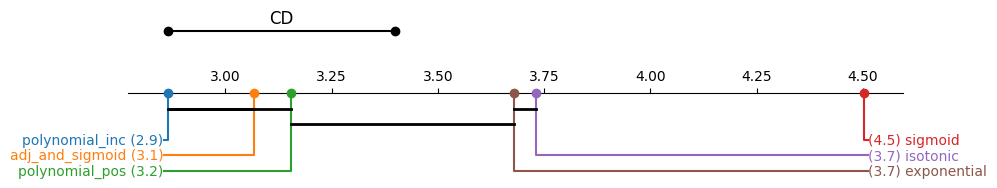

In [14]:
test_results.columns = ["isotonic", "sigmoid", "adj_and_sigmoid", "polynomial_pos", "polynomial_inc", "exponential"]
test_results.index = test_results.columns
avg_rank.index = test_results.columns

plt.figure(figsize=(10, 2), dpi=100)
sp.critical_difference_diagram(avg_rank, test_results) # At 0.95 confidence rate
plt.plot([avg_rank.min(), avg_rank.min() + CD], [4, 4], marker="o", color="black")
plt.text(avg_rank.min() + CD/2, 4.5, "CD", fontsize=12, horizontalalignment="center")
plt.show()

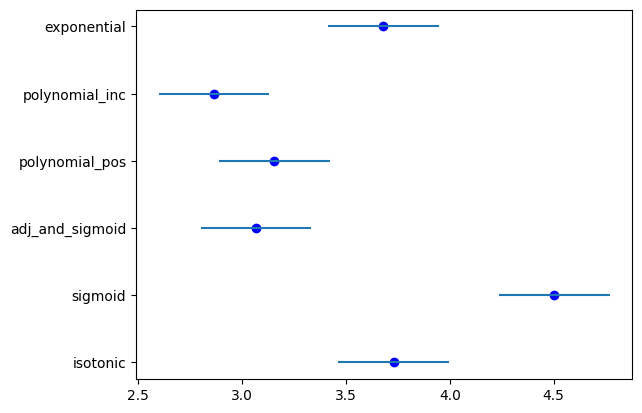

In [15]:
for method in avg_rank.index:
    plt.hlines(y = method, xmin = avg_rank[method] - CD/2, xmax = avg_rank[method] + CD/2)
    plt.scatter(avg_rank[method], method, color="b")

plt.show()

# Other visualization for statistical validation

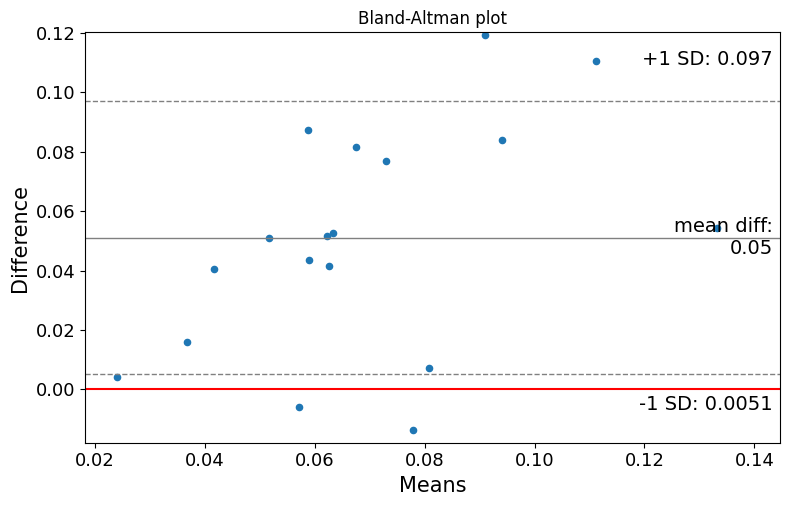

In [16]:
import statsmodels.api as sm

avg_ece_all_iterations = get_error_all_iterations(calib_errors_all_metric_all_datasets, method_selec_plot, "Avg_ECE_top_k", threshold=None)

#create Bland-Altman plot                  
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(avg_ece_all_iterations["California_13%"]["isotonic"], avg_ece_all_iterations["California_13%"]["polynomial_pos"], ax = ax, sd_limit=1)

#display Bland-Altman plot
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.title("Bland-Altman plot")
plt.show()

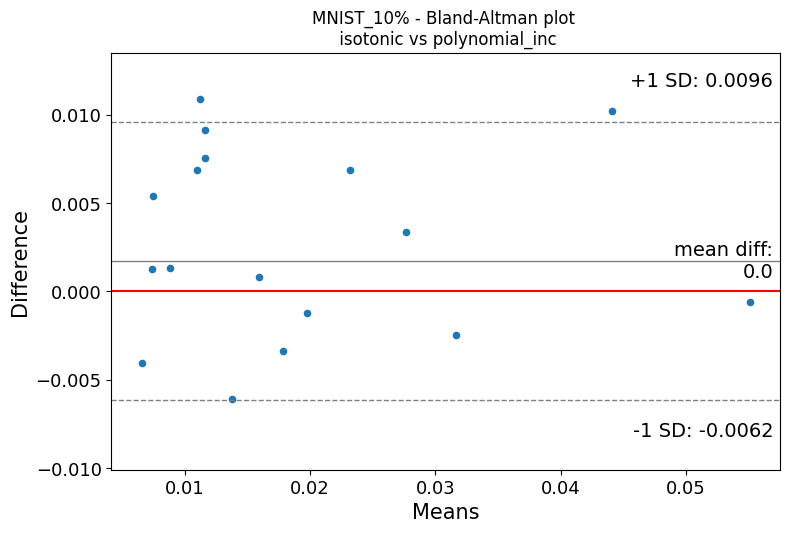

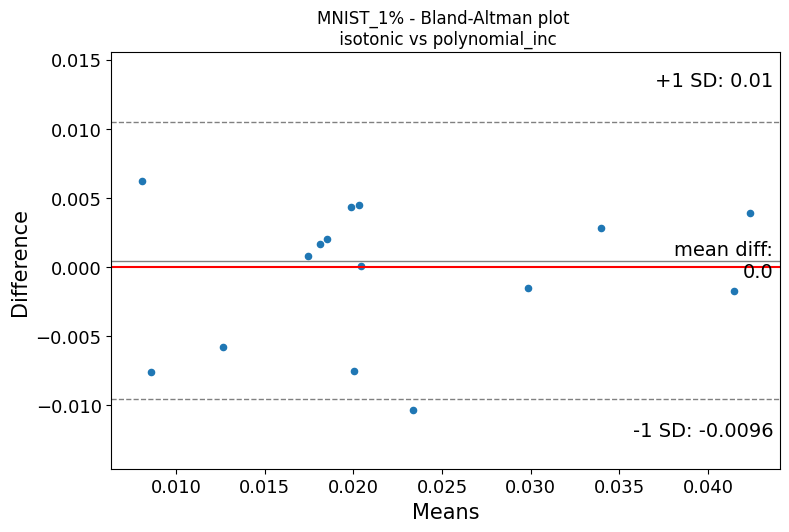

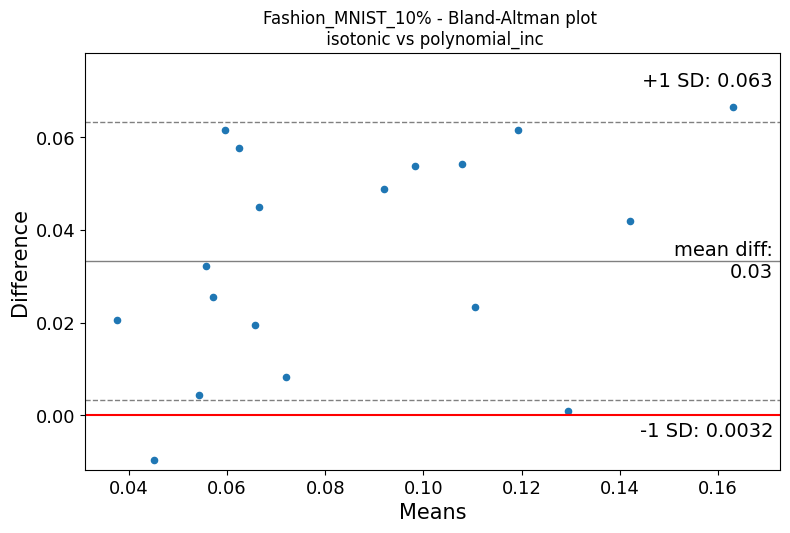

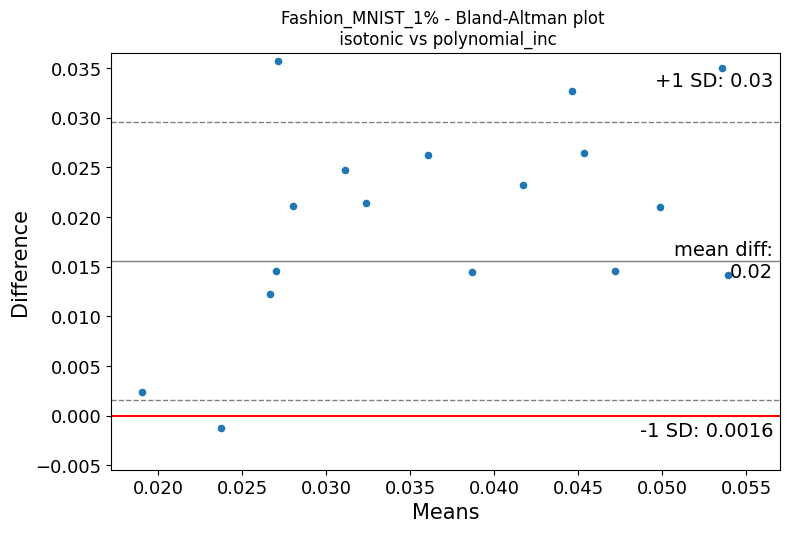

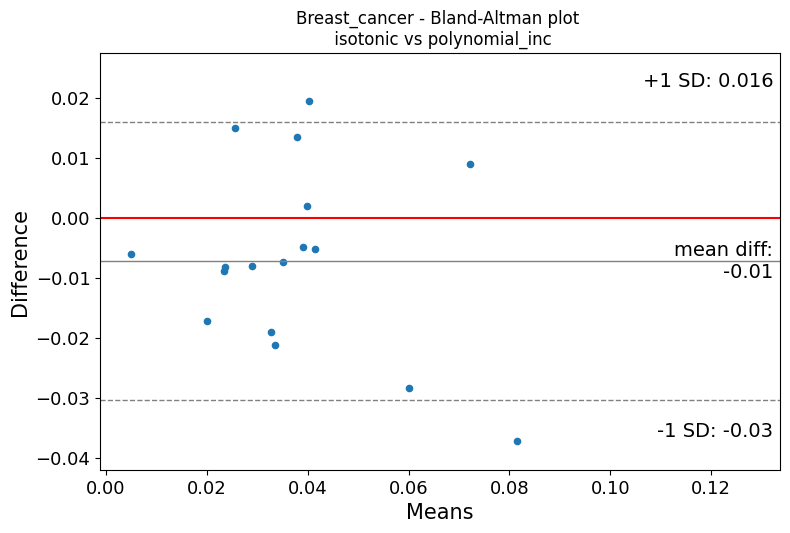

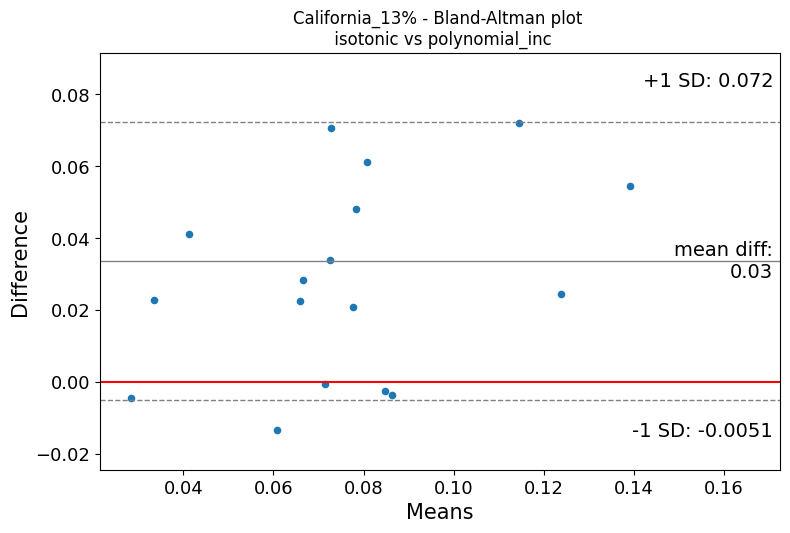

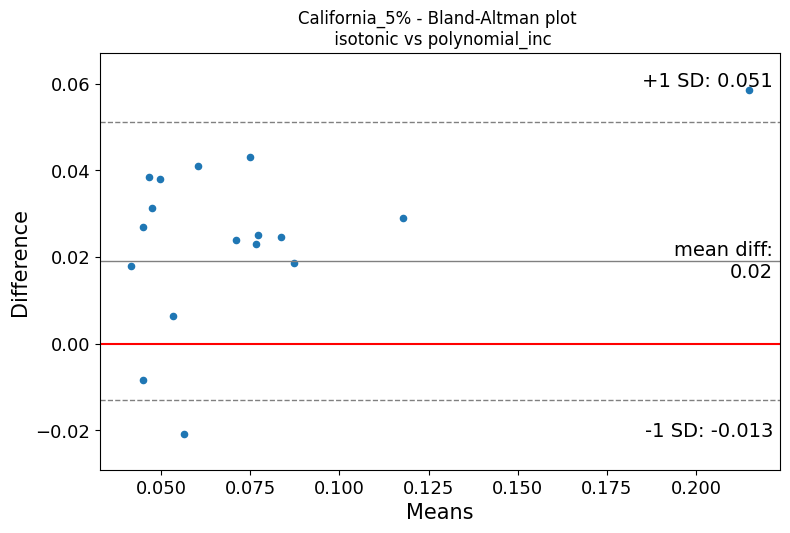

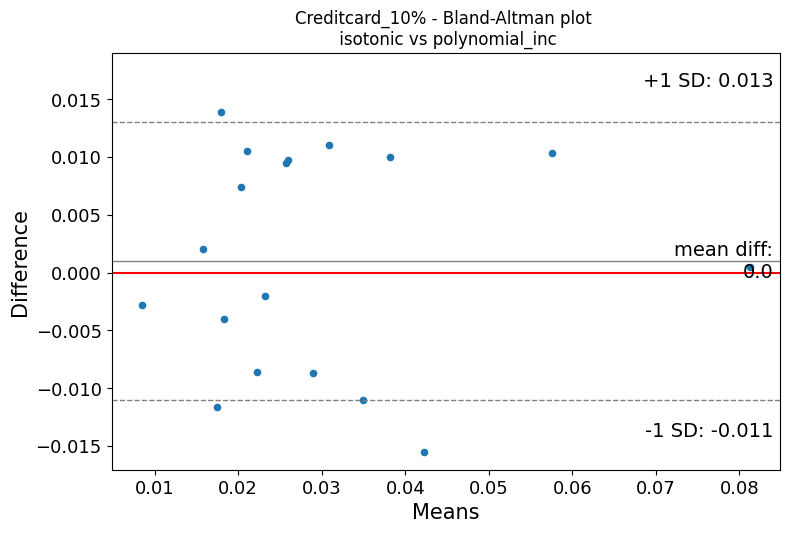

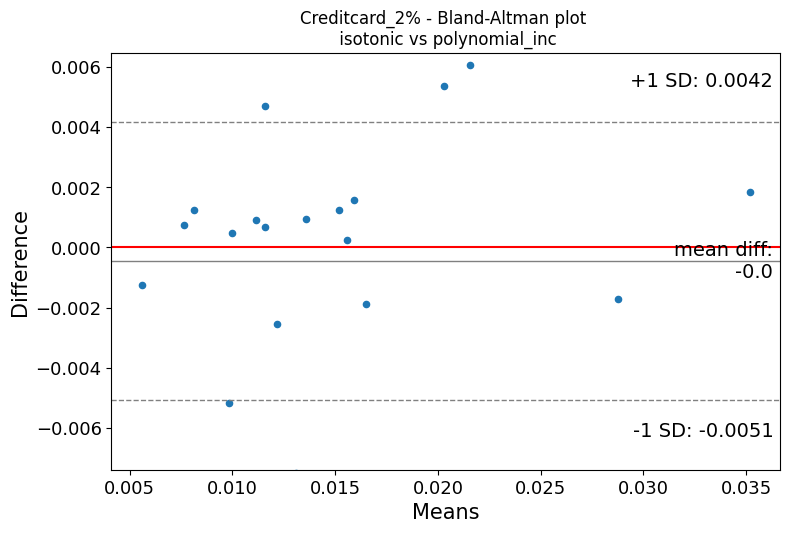

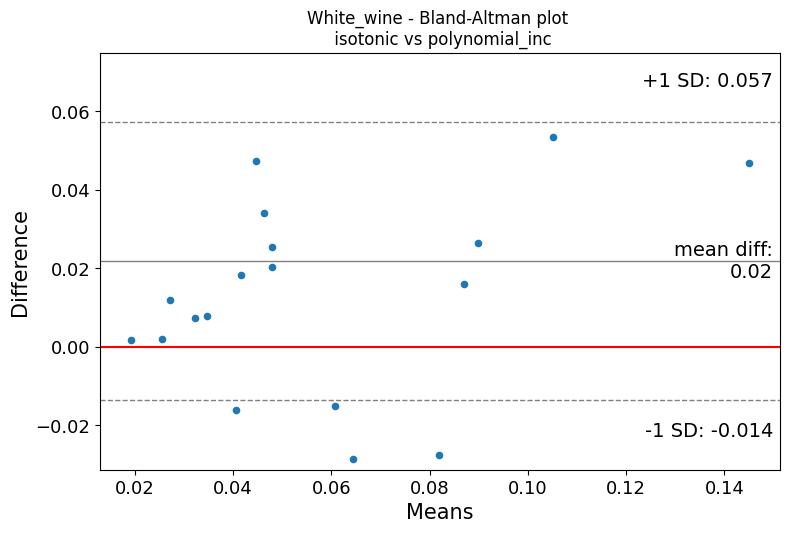

In [17]:
for dataset in calib_errors_all_metric_all_datasets.keys():
    for method in avg_ece_all_iterations[dataset].columns:
        if method != "polynomial_inc" and method == "isotonic":
            #create Bland-Altman plot                  
            f, ax = plt.subplots(1, figsize = (8,5))
            sm.graphics.mean_diff_plot(avg_ece_all_iterations[dataset][method], avg_ece_all_iterations[dataset]["polynomial_inc"], ax = ax, sd_limit=1)

            #display Bland-Altman plot
            plt.axhline(y = 0, color = 'r', linestyle = '-')
            plt.title("%s - Bland-Altman plot \n %s vs polynomial_inc" % (dataset, method))
            plt.show()